In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix

In [6]:
dataset_dir = 'dataset'

In [7]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25)

In [8]:
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training',
    seed=107)

Found 1590 images belonging to 2 classes.


In [9]:
validation_generator = datagen.flow_from_directory(
    dataset_dir, 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='validation',
    seed=107)

Found 530 images belonging to 2 classes.


In [10]:
imgs, labels = next(train_generator)

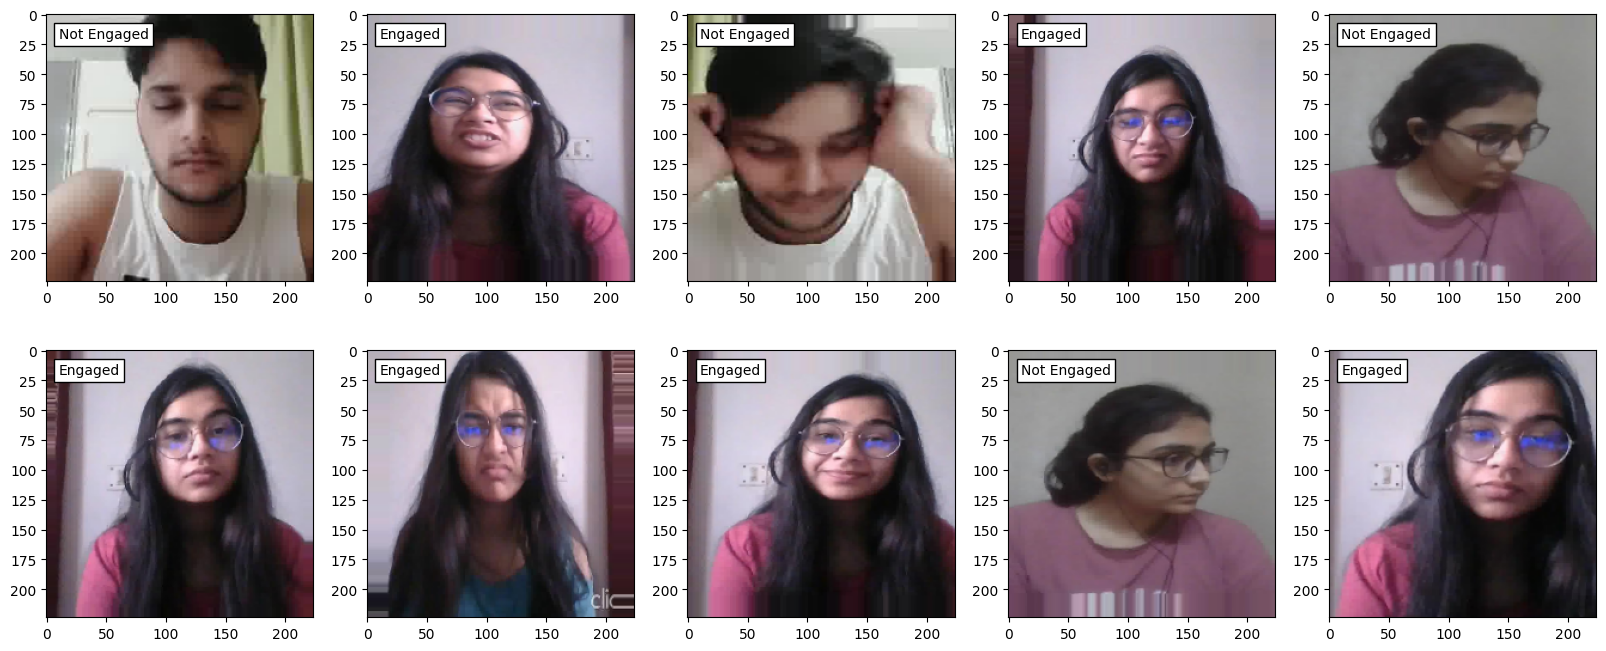

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for img, ax, label in zip(imgs, axes, labels):
    ax.imshow(img)
    if label==0: text='Engaged'
    else: text='Not Engaged'
    ax.text(10, 20, text, bbox={'facecolor': 'white', 'pad': 3})

plt.show()

In [13]:
import keras
from keras.applications import ResNet50V2

base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False



In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = Sequential([]) (inputs)
x = keras.applications.resnet_v2.preprocess_input(x),
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = keras.layers.BatchNormalization()(x) # Introduce batch norm
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

# Flattening to final layer - Dense classifier with 37 units (multi-class classification)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

In [17]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(x=train_generator,
                    validation_data=validation_generator,
                    epochs=10, 
                    verbose=1)

Epoch 1/10
50/50 [==============================] - 56s 1s/step - loss: 0.4046 - accuracy: 0.8453 - val_loss: 0.6593 - val_accuracy: 0.4925
Epoch 2/10
50/50 [==============================] - 52s 1s/step - loss: 0.2162 - accuracy: 0.9270 - val_loss: 0.5592 - val_accuracy: 0.4962
Epoch 3/10
50/50 [==============================] - 55s 1s/step - loss: 0.1669 - accuracy: 0.9491 - val_loss: 0.4428 - val_accuracy: 0.8075
Epoch 4/10
50/50 [==============================] - 55s 1s/step - loss: 0.1416 - accuracy: 0.9623 - val_loss: 0.3543 - val_accuracy: 0.9434
Epoch 5/10
50/50 [==============================] - 55s 1s/step - loss: 0.1169 - accuracy: 0.9704 - val_loss: 0.3191 - val_accuracy: 0.9245
Epoch 6/10
50/50 [==============================] - 55s 1s/step - loss: 0.1069 - accuracy: 0.9673 - val_loss: 0.2547 - val_accuracy: 0.9698
Epoch 7/10
50/50 [==============================] - 59s 1s/step - loss: 0.0914 - accuracy: 0.9748 - val_loss: 0.2260 - val_accuracy: 0.9774
Epoch 8/10
50/50 [==

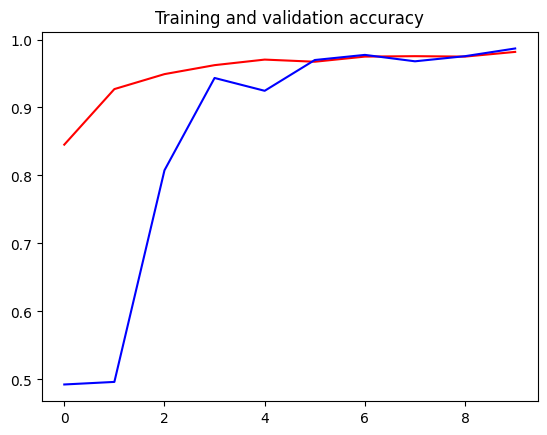

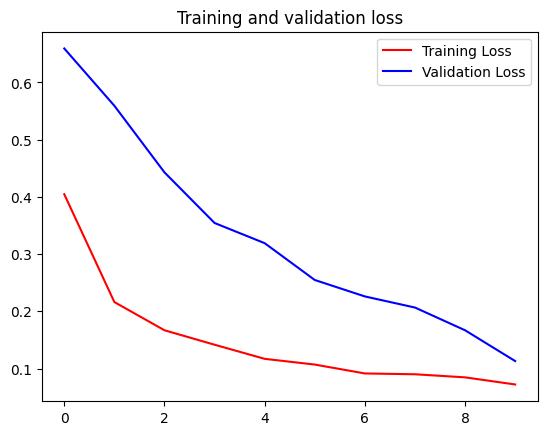

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

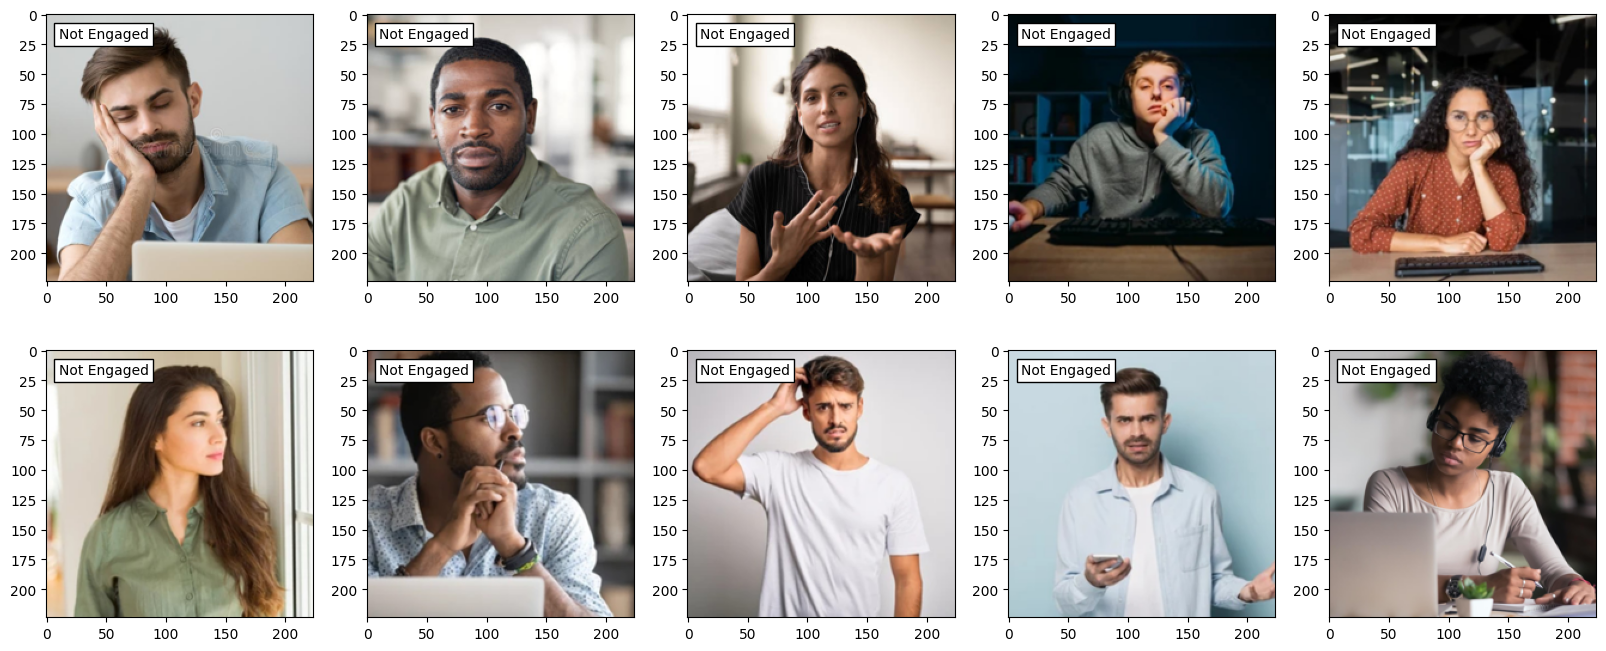

In [24]:
from image_crop import crop_square

test_dir = r'test_dataset'

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for path, ax in zip (os.listdir(test_dir), axes):
    path = os.path.join(test_dir, path)
    
    img = Image.open(path)
    img = crop_square(img)
    img = img.resize((224, 224))

    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    pred = model.predict(images, batch_size=10, verbose=0)
    
    ax.imshow(img)
    if pred[0][0]==0: text='Engaged'
    else: text='Not Engaged'
    ax.text(10, 20, text, bbox={'facecolor': 'white', 'pad': 3})

plt.show()